# Compute spectra from mitgcm outputs


---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(25)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.0:34974 Dashboard: http://10.148.1.0:8787/status,Cluster Workers: 50 Cores: 200 Memory: 2500.00 GB


---

# File location and grid

In [5]:
v = 'SSU'

## open files, nc files
ncdata_dir = '/home1/scratch/xyu/mit_nc_new/'
#ncdata_dir = '/home1/pharos/othr/xyu/mit_nc/'

# dir where spectra are stored
E_dir = '/home1/scratch/xyu/mit_spec/zavg_SSU/'

print(ncdata_dir)
print(E_dir)


# number of fies to load for each face (1 file = 10 days)
Nf = 2

mgrid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])



/home1/scratch/xyu/mit_nc_new/
/home1/scratch/xyu/mit_spec/zavg_SSU/


# one-point test

## one point(i=50, j=50) on face 1

In [6]:
face = 1    

filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
filenames = filenames[:Nf]

grid = mgrid.isel(face=face)
ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')    
chunks={'time': len(ds['time'])}
ds = ds.chunk(chunks)

SSU = ds[v]
print(ds)

<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 2880)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
    dtime    (time) datetime64[ns] dask.array<shape=(2880,), chunksize=(2880,)>
Data variables:
    SSU      (i, j, time) float32 dask.array<shape=(4320, 4320, 2880), chunksize=(10, 432, 2880)>


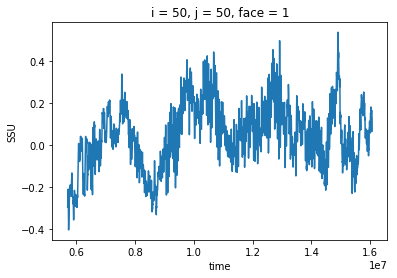

In [7]:
SSU.isel(i=50,j=50).plot()

## FFT on u, applying a hanning window

In [8]:
u_normal = SSU.isel(i=50,j=50)
print(u_normal)

<xarray.DataArray 'SSU' (time: 2880)>
dask.array<shape=(2880,), dtype=float32, chunksize=(2880,)>
Coordinates:
    i        int64 50
    j        int64 50
    face     int64 1
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
    dtime    (time) datetime64[ns] dask.array<shape=(2880,), chunksize=(2880,)>


In [9]:
u_detrend = u_normal - u_normal.mean()

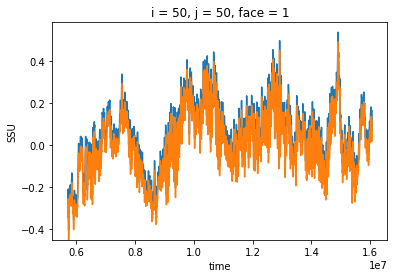

In [10]:
SSU.isel(i=50,j=50).plot()
u_detrend.plot()

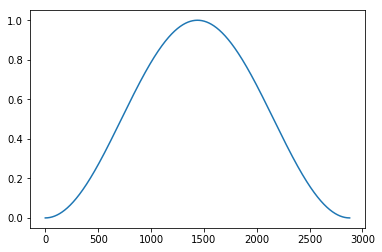

In [14]:
nfft = 2880  # 24hours * 60 = 60 days 
window = np.hanning(nfft)
u_normal_w = u_normal*window

plt.plot(window)

In [12]:

u_fft_normal = xrft.dft(u_normal.fillna(0.), shift=False, detrend='linear', window=True)
E_u_normal = (u_fft_normal*u_fft_normal.conj()).where(u_fft_normal!=0., drop=False)/2880*3600
print(E_u_normal)
E_u_normal = np.real(E_u_normal).rename('u_power_spectrum')


<xarray.DataArray 'fftn-9cdb6403aa18dd2d5e41e98c0bc68e53' (freq_time: 2880)>
dask.array<shape=(2880,), dtype=complex128, chunksize=(2880,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.645e-08 1.929e-07 2.894e-07 ...
    freq_time_spacing  float64 9.645e-08


In [19]:
u_normal = SSU.isel(i=50,j=50)

u_fft_normal_2 = xrft.dft(window*u_normal.fillna(0.), shift=False, detrend='linear', window=False)
E_u_normal_2 = (u_fft_normal_2*u_fft_normal_2.conj()).where(u_fft_normal_2!=0., drop=False)/2880*3600
print(E_u_normal_2)
E_u_normal_2 = np.real(E_u_normal_2).rename('u_power_spectrum')



<xarray.DataArray 'fftn-227ce6dca5d930b79ed066f196eebbad' (freq_time: 2880)>
dask.array<shape=(2880,), dtype=complex128, chunksize=(2880,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.645e-08 1.929e-07 2.894e-07 ...
    freq_time_spacing  float64 9.645e-08


No handles with labels found to put in legend.


(0.001, 100000.0)

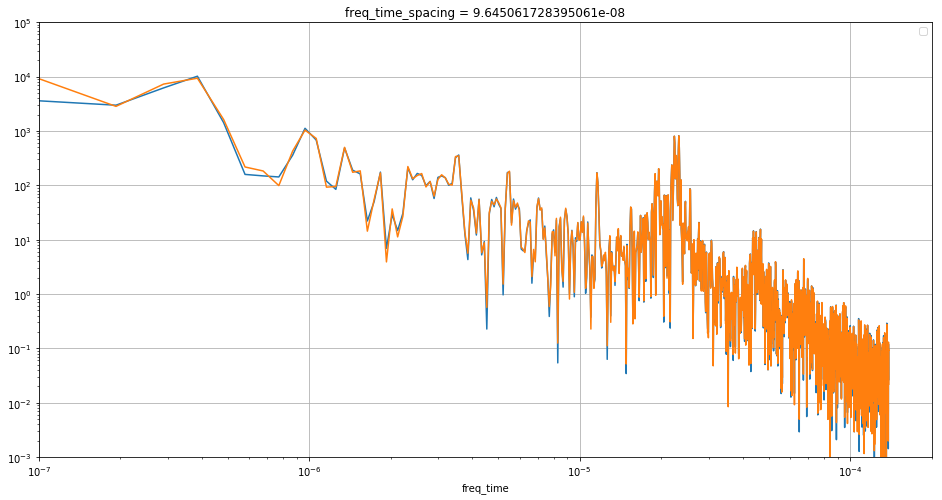

In [20]:
fig, ax = plt.subplots(figsize=(16,8))

E_u_normal.where(E_u_normal.freq_time>0).plot(ax=ax)
E_u_normal_2.where(E_u_normal_2.freq_time>0).plot(ax=ax)


ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_xlim([1e-7,2*1e-4])
ax.set_ylim([1e-3,1e5])

In [13]:
# diff_f

df=E_u_normal.freq_time[1]-E_u_normal.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(9.645062e-08)
Coordinates:
    freq_time_spacing  float64 9.645e-08


In [14]:
(E_u_normal*df).sum(dim='freq_time').compute()

<xarray.DataArray ()>
array(0.009348)
Coordinates:
    freq_time_spacing  float64 9.645e-08

In [15]:
(E_u_normal_2*df).sum(dim='freq_time').compute()

<xarray.DataArray ()>
array(0.008371)
Coordinates:
    freq_time_spacing  float64 9.645e-08

## Applying a hanning window on u

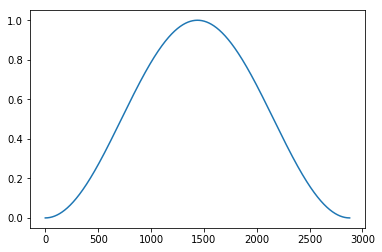

In [16]:
nfft = 2880  # 24hours * 60 = 60 days 
window = np.hanning(nfft)
u_normal_w = u_normal*window

plt.plot(window)

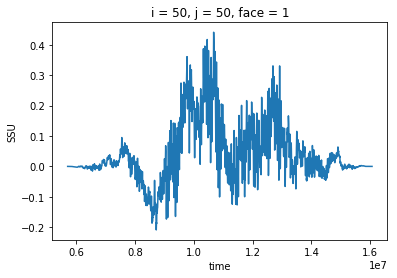

In [13]:
u_normal_w.plot()

In [17]:
u_normal_w.var(dim='time').compute()

<xarray.DataArray 'SSU' ()>
array(0.009424)
Coordinates:
    i        int64 50
    j        int64 50
    face     int64 1

In [19]:
(u_normal_w*u_normal_w).mean(['time']).compute() # SSU^2 mean

<xarray.DataArray 'SSU' ()>
array(0.011041)
Coordinates:
    i        int64 50
    j        int64 50
    face     int64 1

In [11]:
cluster.scheduler.close()

<Future finished result=None>